<a href="https://colab.research.google.com/github/rukka0808/Deep-Learning-Study/blob/main/EU_lane_Perfect_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
def wrapping(image):
    (h, w) = (image.shape[0], image.shape[1])

    pts1 = np.float32([[450,350],[370,480],[575,350],[740,480]])
    #pts2 = np.float32([[250,0],[250,1000],[850,0],[850,1000]])
    #source = np.float32([[w // 2 - 30, h * 0.53], [w // 2 + 60, h * 0.53], [w * 0.3, h], [w, h]])
    #destination = np.float32([[0, 0], [w-350, 0], [400, h], [w-150, h]])
    pts2 = np.float32([[w*0.25, 0],[w*0.25,h],[ w*0.75 ,0],[w*0.75,h]])

    transform_matrix = cv2.getPerspectiveTransform(pts1, pts2)
    minv = cv2.getPerspectiveTransform(pts1, pts2)
    _image = cv2.warpPerspective(image, transform_matrix, (w, h))

    return _image, minv

In [3]:
def color_filter(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    lower = np.array([20, 20, 20])
    upper = np.array([255, 255, 255])

    yellow_lower = np.array([0, 85, 81])
    yellow_upper = np.array([190, 255, 255])

    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)
    white_mask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)

    return masked

In [34]:
def roi(image):
    x = int(image.shape[1])
    y = int(image.shape[0])

    # 한 붓 그리기
    _shape = np.array(
        [[int(0.1*x), int(y)], [int(0.1*x), int(0.1*y)], [int(0.4*x), int(0.1*y)], [int(0.4*x), int(y)], [int(0.55*x), int(y)], [int(0.55*x), int(0.1*y)],[int(0.80*x), int(0.1*y)], [int(0.80*x), int(y)], [int(0.2*x), int(y)]])

    mask = np.zeros_like(image)

    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, np.int32([_shape]), ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)

    return masked_image

In [5]:
_gray = cv2.cvtColor(w_f_r_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(_gray, 160, 255, cv2.THRESH_BINARY)

NameError: ignored

In [7]:
def plothistogram(image):
    histogram = np.sum(image[image.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftbase = np.argmax(histogram[:midpoint])
    rightbase = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftbase, rightbase

In [20]:
def slide_window_search(binary_warped, left_current, right_current):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    nwindows = 4
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()  # 선이 있는 부분의 인덱스만 저장
    nonzero_y = np.array(nonzero[0])  # 선이 있는 부분 y의 인덱스 값
    nonzero_x = np.array(nonzero[1])  # 선이 있는 부분 x의 인덱스 값
    margin = 100
    minpix = 50
    left_lane = []
    right_lane = []
    color = [0, 255, 0]
    thickness = 2

    for w in range(nwindows):
        win_y_low = binary_warped.shape[0] - (w + 1) * window_height  # window 윗부분
        win_y_high = binary_warped.shape[0] - w * window_height  # window 아랫 부분
        win_xleft_low = left_current - margin  # 왼쪽 window 왼쪽 위
        win_xleft_high = left_current + margin  # 왼쪽 window 오른쪽 아래
        win_xright_low = right_current - margin  # 오른쪽 window 왼쪽 위
        win_xright_high = right_current + margin  # 오른쪽 window 오른쪽 아래

        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), color, thickness)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), color, thickness)
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        left_lane.append(good_left)
        right_lane.append(good_right)
        # cv2.imshow("oo", out_img)

        if len(good_left) > minpix:
            left_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > minpix:
            right_current = np.int(np.mean(nonzero_x[good_right]))

    left_lane = np.concatenate(left_lane)  # np.concatenate() -> array를 1차원으로 합침
    right_lane = np.concatenate(right_lane)

    leftx = nonzero_x[left_lane]
    lefty = nonzero_y[left_lane]
    rightx = nonzero_x[right_lane]
    righty = nonzero_y[right_lane]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    ltx = np.trunc(left_fitx)  # np.trunc() -> 소수점 부분을 버림
    rtx = np.trunc(right_fitx)

    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]

    #plt.imshow(out_img)
    # plt.plot(left_fitx, ploty, color = 'yellow')
    # plt.plot(right_fitx, ploty, color = 'yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    # plt.show()
    #plt.plot(left_fit)
    #plt.show()
    ret = {'left_fitx' : ltx, 'right_fitx': rtx, 'ploty': ploty}

    return ret

In [28]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (216, 168, 74))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (216, 168, 74))
    
    (h, w) = (original_image.shape[0], original_image.shape[1])
    pts1 = np.float32([[450,350],[370,480],[575,350],[740,480]])
    pts2 = np.float32([[w*0.25, 0],[w*0.25,h],[ w*0.75 ,0],[w*0.75,h]])

    invTransMaxtirx = cv2.getPerspectiveTransform(pts2, pts1)

    newwarp = cv2.warpPerspective(color_warp, invTransMaxtirx, (original_image.shape[1], original_image.shape[0]))
    #cv2_imshow(newwarp)
    result = cv2.addWeighted(original_image, 1, newwarp, 0.4, 0)

    return pts_mean, result

In [22]:
from google.colab import files
upload = files.upload()
img = cv2.imread('EU_test_Moment(4).jpg')

Saving EU_test_Moment(4).jpg to EU_test_Moment(4) (1).jpg


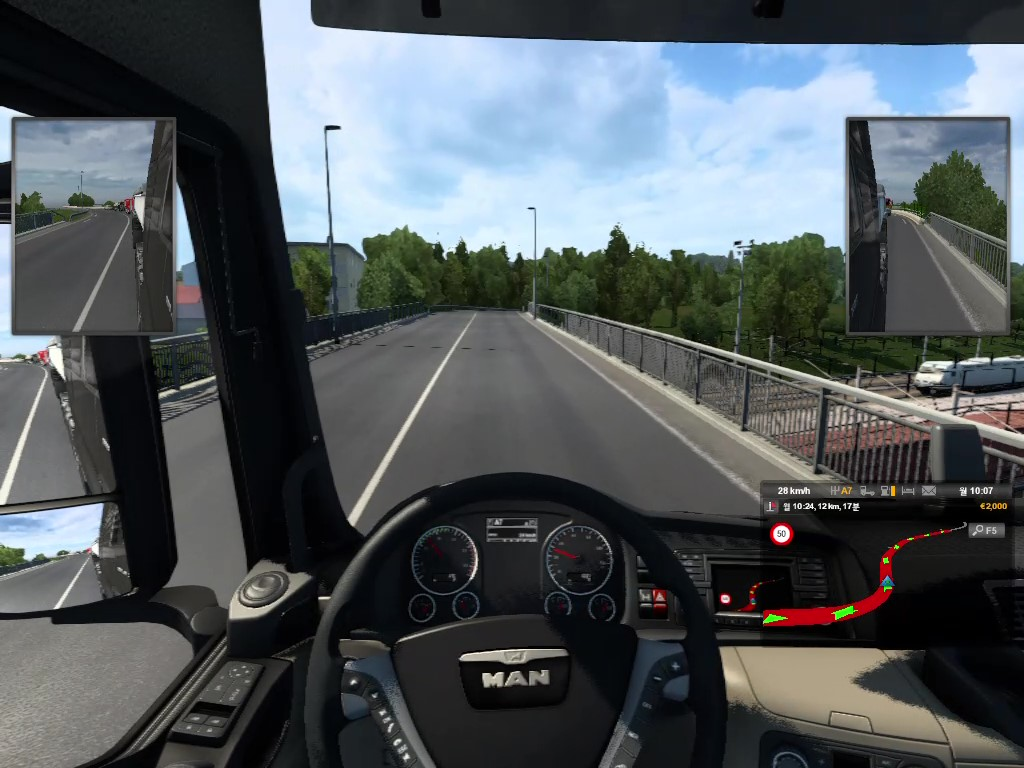

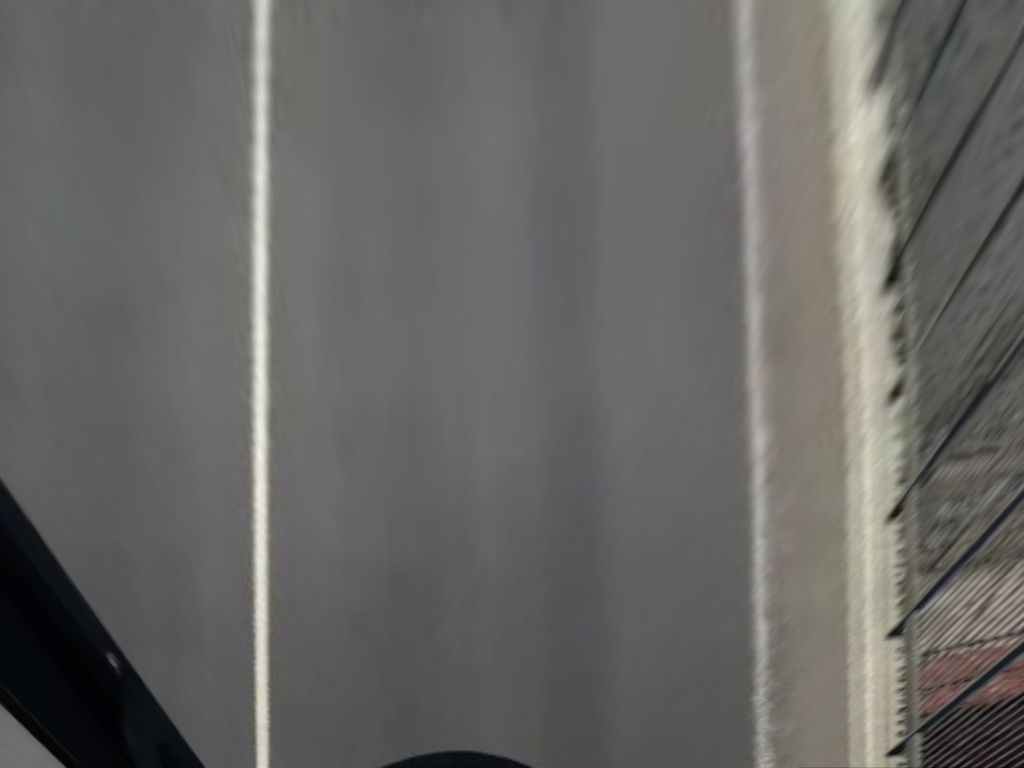

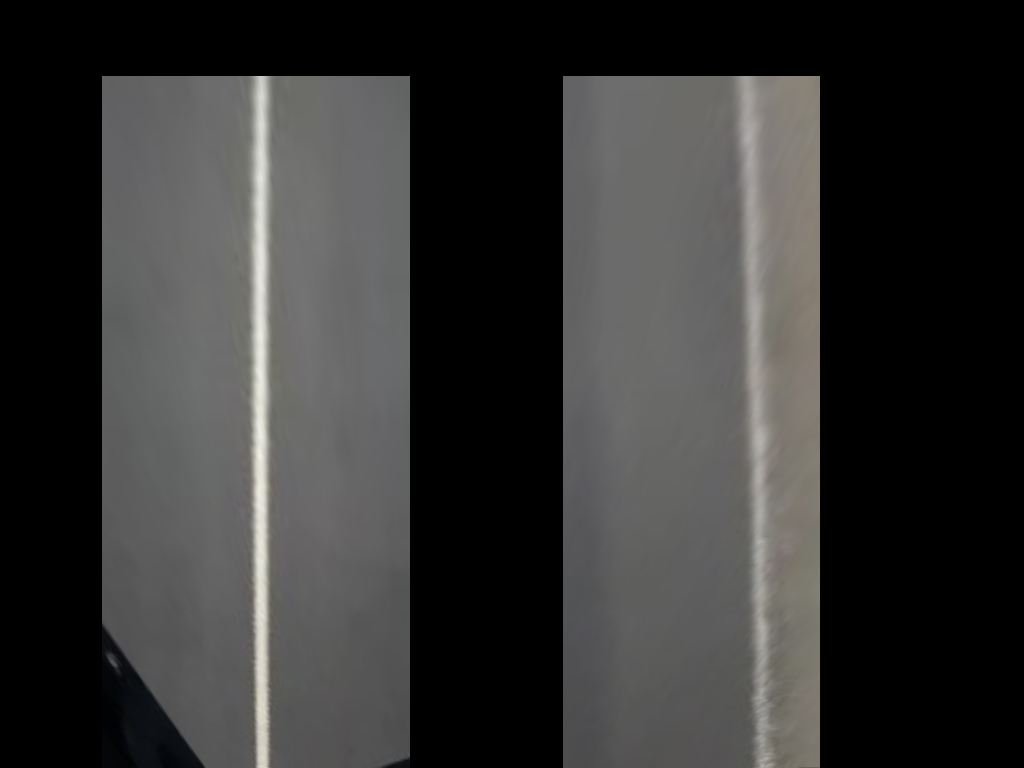

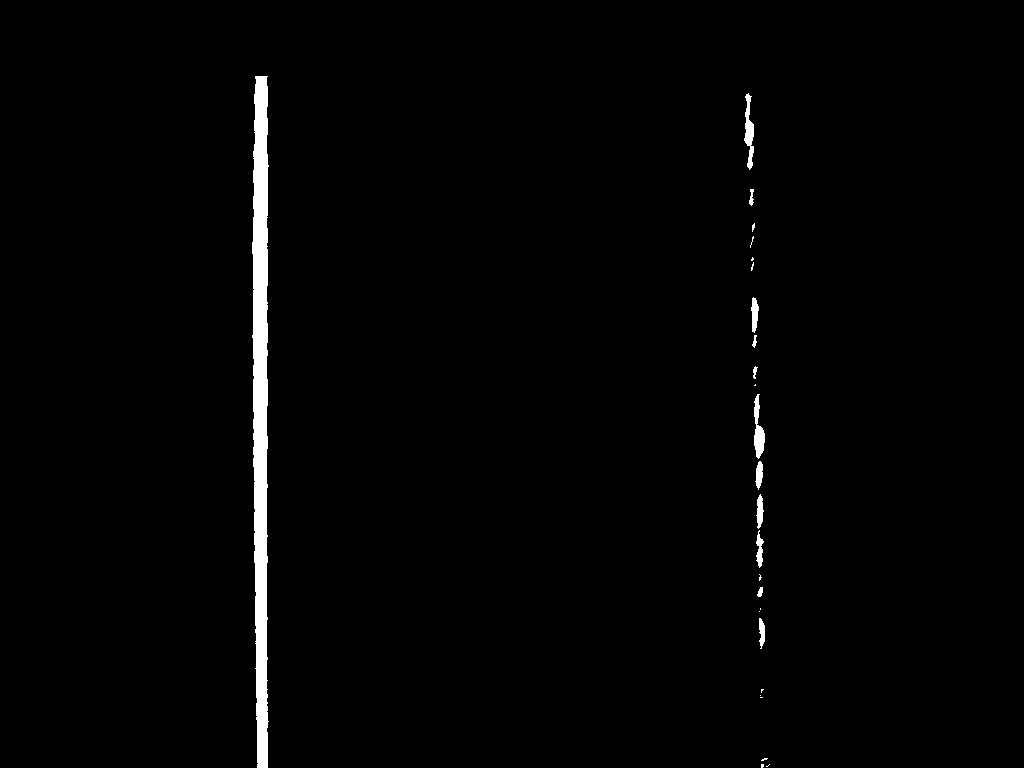

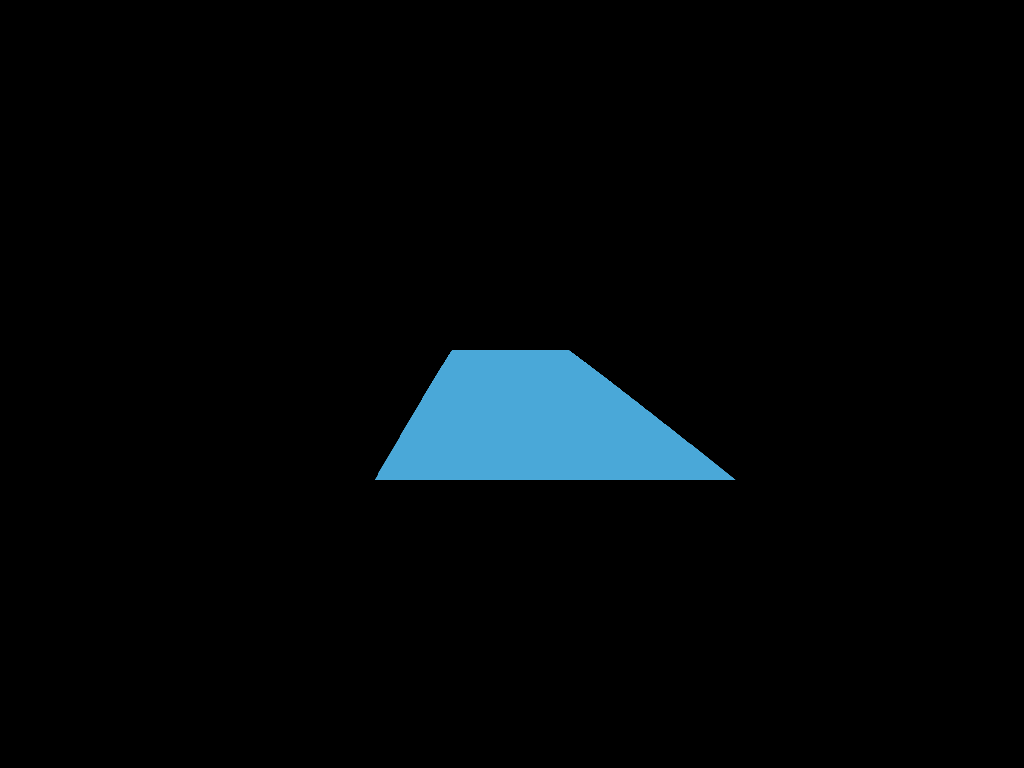

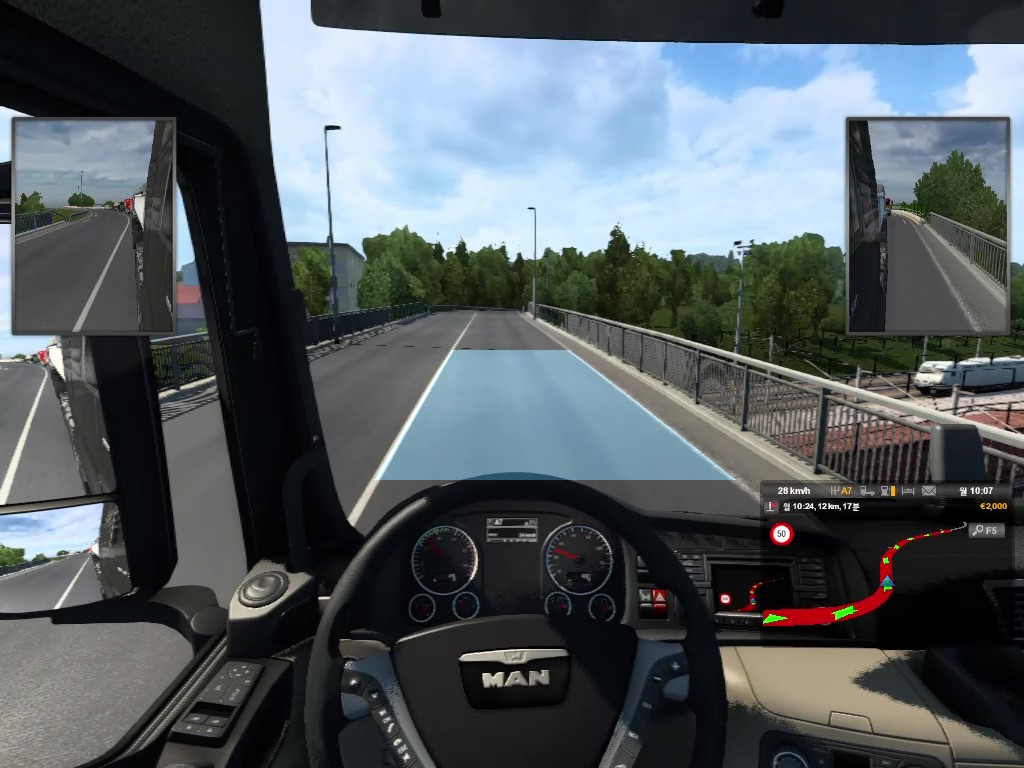

In [36]:
wrapped_img, minverse = wrapping(img)
cv2_imshow(img)
cv2_imshow(wrapped_img)

#print(minverse)
# #조감도 필터링 자르기
test_img = roi(wrapped_img)
cv2_imshow(test_img)

## 조감도 필터링
#w_f_r_img = color_filter(test_img)
#cv2_imshow(w_f_r_img)



# # 조감도 선 따기 wrapped img threshold
_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(_gray, 160, 255, cv2.THRESH_BINARY)
cv2_imshow( thresh)

# # 선 분포도 조사 histogram
leftbase, rightbase = plothistogram(thresh)
# plt.plot(hist)
# plt.show()

# # histogram 기반 window roi 영역
draw_info = slide_window_search(thresh, leftbase, rightbase)
#plt.plot(left_fit)
#plt.show()

# # 원본 이미지에 라인 넣기
meanPts, result = draw_lane_lines(img, thresh, minverse, draw_info)
cv2_imshow(result)